<img src="../img/logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales
# Semana 5:
#### Nicolas Pereyra
---
## Consigna:

### TS5: Simulación de un ADC (cuantización, muestreo y alias)

En esta tarea semanal integraremos las tres TS anteriores, para llegar a una simulación más completa del funcionamiento de una ADC. Para ello, vamos a completar la simulación del ADC incluyendo la capacidad de muestrear a $f_{s}$, simulando una señal analógica que estará muestreada a $f_{s}=k_{O}.f_{s} Hz$, siendo $k_{O}$ el factor de sobremuestreo.

Continuaremos con el mismo setup experimental de la TS anterior. Adoptar igual potencia de ruido analógica que potencia producto del ruido de cuantización ($k_{n}=1$)

Se pide:

1) Genere al menos 3 situaciones que demuestren el efecto del alias cuando no se usa correctamente el filtro pasabajo de desambiguación o anti-alias.

Ayuda:

    Simular el filtro analógico con un filtro digital IIR Butterworth.

## Resolucion:
### Filtro IIR:
Comenzaremos la resolución de este ejercicio diseñando funciones para la creación de un filtro IIR tipo Butterworth. Estas funciones nos permiten desarrollar de manera rápida y sencilla filtros IIR con una plantilla de comparación que facilita verificar si cumplen con las especificaciones. Además, se implementó una función para desnormalizar la respuesta del filtro, permitiendo adaptarlo a una frecuencia de muestreo real.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

def graficar_filtro_iir_(fc, orden, f_objetivo, atenuacion_rechazo_db, atenuacion_paso_db=-3, fs=1.0):
    """
    Genera y grafica un filtro IIR Butterworth con parámetros dados.
    
    Parámetros:
    - fc: frecuencia de corte en Hz
    - orden: orden del filtro
    - f_objetivo: frecuencia objetivo donde se espera la atenuación de rechazo (Hz)
    - atenuacion_rechazo_db: dB deseados de rechazo a partir de f_objetivo (negativo)
    - atenuacion_paso_db: dB máximos permitidos en la banda de paso (default 0 dB)
    - fs: frecuencia de muestreo en Hz
    
    Retorna:
    - b, a: coeficientes del filtro IIR (numerador y denominador)
    """
    
    # Frecuencia de corte normalizada (para diseño digital)
    fc_norm = fc / (fs / 2)
    
    # Diseño del filtro Butterworth
    b, a = sig.butter(orden, fc_norm, btype='low', analog=False)

    # Respuesta en frecuencia
    worN = 1024
    w, h = sig.freqz(b, a, worN=worN)
    
    # Frecuencia normalizada para graficar (de 0 a 1)
    f = w / np.pi
    h_db = 20 * np.log10(np.abs(h) + 1e-12)  # +1e-12 para evitar log(0)

    # Rango de dB para la gráfica
    y_min, y_max = -100, 5

    # Crear figura
    plt.figure(figsize=(10, 6))
    plt.plot(f, h_db, label='Respuesta en frecuencia', color='blue')

    # Banda de paso (zona gris clara): desde 0 a fc, entre y_min y atenuacion_paso_db
    f_band_paso = [0, fc / (fs / 2)]
    plt.fill_between(f_band_paso, y_min, atenuacion_paso_db, color='gray', alpha=0.3, label='Zona de paso')

    # Banda de rechazo: desde f_objetivo hasta 1, entre y_max y atenuacion_rechazo_db
    f_band_rechazo = [f_objetivo / (fs / 2), 1]
    plt.fill_between(f_band_rechazo, y_max, atenuacion_rechazo_db, color='gray', alpha=0.5, label='Zona de rechazo')

    # Líneas guía
    plt.axhline(y=atenuacion_paso_db, color='green', linestyle='--', label=f'Límite paso: {atenuacion_paso_db} dB')
    plt.axhline(y=atenuacion_rechazo_db, color='red', linestyle='--', label=f'Rechazo en f={f_objetivo} Hz: {atenuacion_rechazo_db} dB')

    # Estética
    plt.title('Filtro IIR Butterworth (normalizado)')
    plt.xlabel('Frecuencia Normalizada (×π rad/sample)')
    plt.ylabel('Magnitud (dB)')
    plt.grid(True)
    plt.ylim([y_min, y_max])
    plt.xlim([0, 1])
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return b, a

#### Ejemplo:

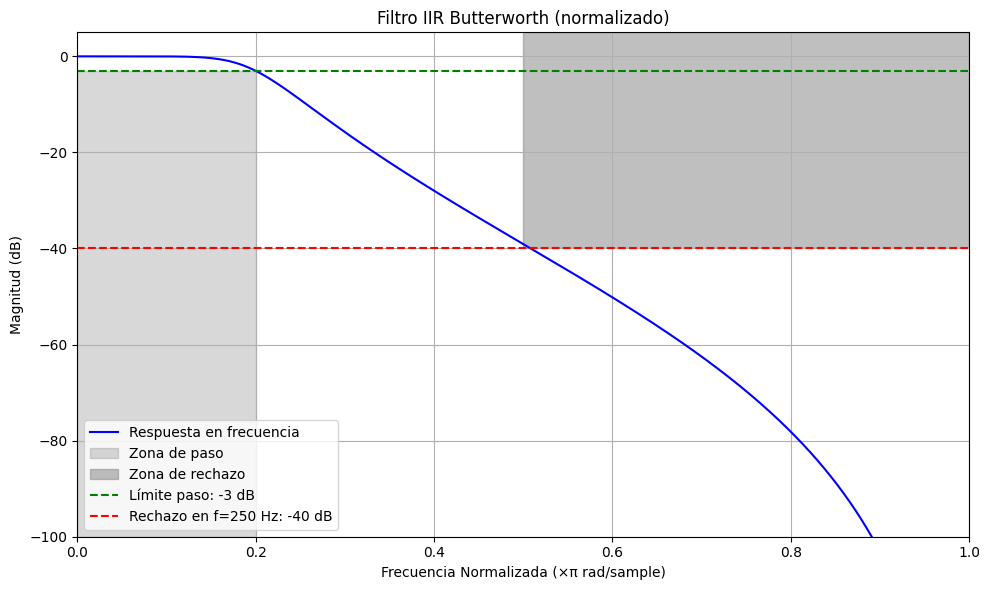

In [2]:
fc = 100         # Frecuencia de corte en Hz
orden = 4        # Orden del filtro
f_objetivo = 250 # Donde quiero que empiece a rechazar fuertemente
atenuacion_rechazo_db = -40
fs = 1000        # Frecuencia de muestreo

b, a = graficar_filtro_iir_(fc, orden, f_objetivo, atenuacion_rechazo_db, fs=fs)


### Volviendo con el Objetivo del TS:
Se nos pide sobre mostrear una señal conun factor de $K_{O}$ con una igual potencia de ruido cuantizado y analogico ($K_{n} = 1$). Con estos datos se nos pide filtrar la señal señal por un filtro Butterworth (el cual elegimos para asimilarlo con un filtro real) y luego de este filtrado realizar un submuestreo o diezmado de la señal. El objetivo de esta TS es observar como varia la transferencia segun las carracteristicas del filtro. Por ejemplo con lo desarrollado en la TS4 podemos observar que en Nysquit vamos a requeir una $SNR$ del orden de $SNR_{q} = 6.02 * B + 1.76$ ($SNR_{4 bits}=25.84 dB$) en caso de no tener esta relacion señal ruido tendremos un efecto de alias el cual introducira mas ruido a nuestro filtro.

## Señal base:
A continuacion se nos mostrara la misma señal presentada en la TS4 para tenerla de ejemplo, esta pose un ADC de $4 bits$, una $f_{s}=1kHz$ y una señal en $10Hz$ y otra en $400Hz$. A esta señal le aplicaremos los diferentes filtros para luego realizar un diezmado.

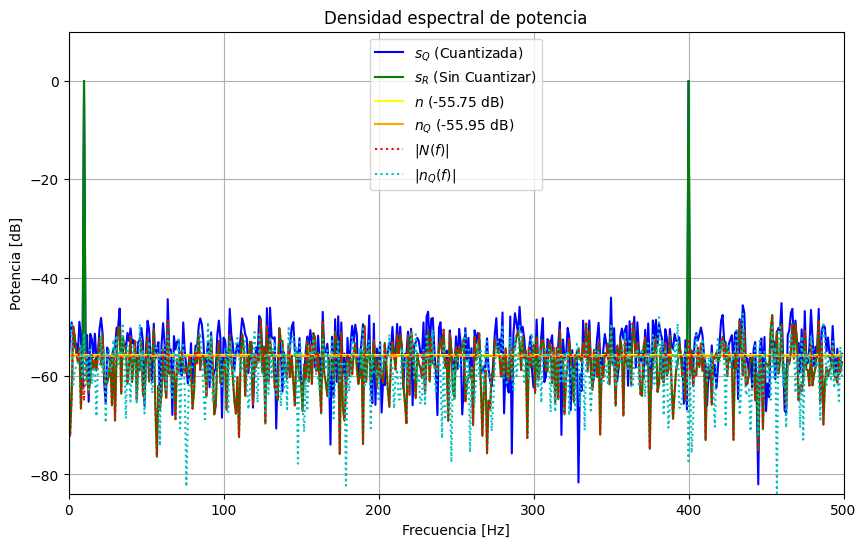

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

# Datos generales
fs = 1000.0
N = 1000

# ADC
B = 4
Vf = 2
q = Vf / 2**B

# Ruido
kn = 1
Pq = q**2 / 12
Pn = kn * Pq

# Ruido gaussiano
n = np.random.normal(0, np.sqrt(Pn), size=N)  # Ruido analógico de la señal

# Tiempo
ts = 1 / fs
tt = np.arange(0, N) * ts

# Señal analógica
f0 = fs / N * 10                    # 10 Hz
f_alias = fs / N * 400              # 400 Hz
omega0 = 2 * np.pi * f0
omega_alias = 2 * np.pi * f_alias

s = np.sqrt(2) * np.sin(omega0 * tt)
s_alias = np.sqrt(2) * np.sin(omega_alias * tt)

s = s + s_alias                       # Señal analógica (Sumo el efecto de ambas señales)

sr = s + n                            # Señal sin cuantizar pero con ruido
srq = q * np.floor(sr / q + 0.5)      # Señal cuantizada
nq = srq - sr                         # Error de cuantización

# FFTs
ff = np.fft.fftfreq(N, d=ts)
ft_Srq = np.fft.fft(srq) / N
ft_SR = np.fft.fft(sr) / N
ft_Nq = np.fft.fft(nq) / N
ft_S = np.fft.fft(s) / N
ft_N = np.fft.fft(n) / N

# Cálculo de potencias promedio
P_s = np.mean(np.abs(ft_S)**2)
P_n = np.mean(np.abs(ft_N)**2)
P_nq = np.mean(np.abs(ft_Nq)**2)

# Acoto a [0, fs/2]
bfrec = (ff >= 0) & (ff <= fs/2)
ff_valid = ff[bfrec]

# Convertir potencias a dB
n_valor_db = 10 * np.log10(2 * P_n)
nq_valor_db = 10 * np.log10(2 * P_nq)
s_valor_db = 10 * np.log10(2 * P_s)

# Señales a graficar con estilo de línea
curvas = [
    ('$s_Q$ (Cuantizada)', ff_valid, 10 * np.log10(2 * np.abs(ft_Srq[bfrec])**2), 'b', '-'),
    ('$s_R$ (Sin Cuantizar)', ff_valid, 10 * np.log10(2 * np.abs(ft_SR[bfrec])**2), 'g', '-'),
    ('$n$ ({:.2f} dB)'.format(n_valor_db), ff_valid, [n_valor_db]*len(ff_valid), 'yellow', '-'),     # Línea horizontal del ruido analógico
    ('$n_Q$ ({:.2f} dB)'.format(nq_valor_db), ff_valid, [nq_valor_db]*len(ff_valid), 'orange', '-'),  # Línea horizontal del error de cuantización
    ('$|N(f)|$', ff_valid, 10 * np.log10(2 * np.abs(ft_N[bfrec])**2), 'r', ':'),                 # Curva del ruido analógico
    ('$|n_Q(f)|$', ff_valid, 10 * np.log10(2 * np.abs(ft_Nq[bfrec])**2), 'c', ':'),              # Curva del ruido de cuantización
]

# Graficar densidad espectral de potencia
plt.figure(figsize=(10, 6))
for titulo, frec, pot, color, estilo in curvas:
    plt.plot(frec, pot, label=titulo, color=color, linestyle=estilo)

plt.title('Densidad espectral de potencia')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Potencia [dB]')
plt.grid(True)
plt.xlim([0, fs / 2])
plt.ylim((1.5*np.min(10*np.log10(2*np.array([P_nq, P_n, P_s]))), 10))
plt.legend()

plt.show()

### No utilizar filtro anti alias
En el siguiente grafico se puede obserbar la aparecion de una señal con la misma amplitud que nuestra señal de $10Hz$ en una frecuencia de $100Hz$ en la cual originalmente no habia nada.

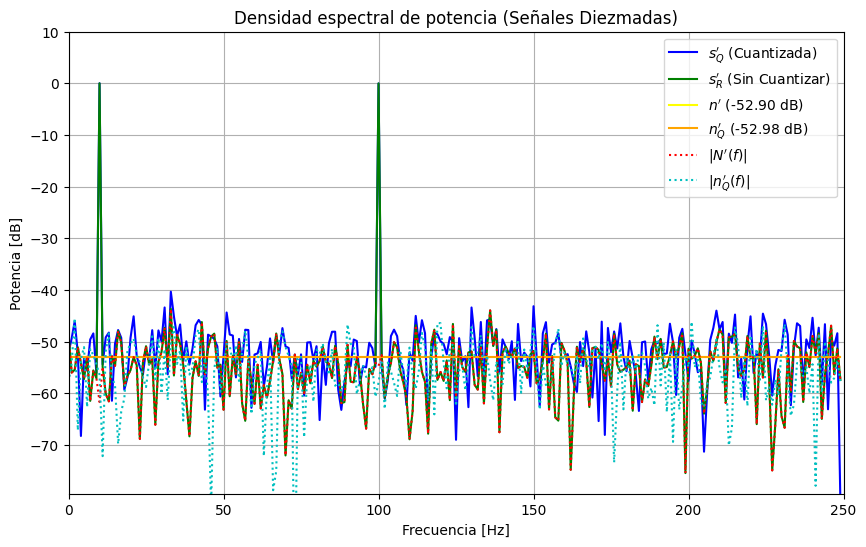

In [4]:
k_o = 2  # Factor de diezmado (en este caso, 2: pasa de fs=1000 a fs=500)

# Nuevos parámetros de muestreo
fs_prima = fs / k_o
ts_prima = 1 / fs_prima

# Diezmado sin filtrado previo (sin antialiasing)
srq_prima = srq[::k_o]
sr_prima = sr[::k_o]
n_prima = n[::k_o]
nq_prima = srq_prima - sr_prima

sr_prima = sr[::k_o]
n_prima = n[::k_o]
nq_prima = srq_prima - sr_prima

# Nuevo vector de tiempo
N_prima = len(srq_prima)
tt_prima = np.arange(N_prima) * ts_prima

# FFTs para señales diezmadas
ff_prima = np.fft.fftfreq(N_prima, d=ts_prima)
ft_Srq_prima = np.fft.fft(srq_prima) / N_prima
ft_SR_prima = np.fft.fft(sr_prima) / N_prima
ft_N_prima = np.fft.fft(n_prima) / N_prima
ft_Nq_prima = np.fft.fft(nq_prima) / N_prima

# Potencias promedio
P_s_prima = np.mean(np.abs(ft_SR_prima)**2)
P_n_prima = np.mean(np.abs(ft_N_prima)**2)
P_nq_prima = np.mean(np.abs(ft_Nq_prima)**2)

# Dominio de frecuencias válido
bfrec_prima = (ff_prima >= 0) & (ff_prima <= fs_prima/2)
ff_valid_prima = ff_prima[bfrec_prima]

# Potencias en dB
n_valor_db_prima = 10 * np.log10(2 * P_n_prima)
nq_valor_db_prima = 10 * np.log10(2 * P_nq_prima)
s_valor_db_prima = 10 * np.log10(2 * P_s_prima)

# Curvas a graficar (versión diezmada)
curvas_prima = [
    ('$s_Q^\prime$ (Cuantizada)', ff_valid_prima, 10 * np.log10(2 * np.abs(ft_Srq_prima[bfrec_prima])**2), 'b', '-'),
    ('$s_R^\prime$ (Sin Cuantizar)', ff_valid_prima, 10 * np.log10(2 * np.abs(ft_SR_prima[bfrec_prima])**2), 'g', '-'),
    ('$n^\prime$ ({:.2f} dB)'.format(n_valor_db_prima), ff_valid_prima, [n_valor_db_prima]*len(ff_valid_prima), 'yellow', '-'),
    ('$n_Q^\prime$ ({:.2f} dB)'.format(nq_valor_db_prima), ff_valid_prima, [nq_valor_db_prima]*len(ff_valid_prima), 'orange', '-'),
    ('$|N^\prime(f)|$', ff_valid_prima, 10 * np.log10(2 * np.abs(ft_N_prima[bfrec_prima])**2), 'r', ':'),
    ('$|n_Q^\prime(f)|$', ff_valid_prima, 10 * np.log10(2 * np.abs(ft_Nq_prima[bfrec_prima])**2), 'c', ':'),
]

# Graficar densidad espectral de potencia (versión diezmada)
plt.figure(figsize=(10, 6))
for titulo, frec, pot, color, estilo in curvas_prima:
    plt.plot(frec, pot, label=titulo, color=color, linestyle=estilo)

plt.title('Densidad espectral de potencia (Señales Diezmadas)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Potencia [dB]')
plt.grid(True)
plt.xlim([0, fs_prima / 2])
plt.ylim((1.5*np.min(10*np.log10(2*np.array([P_nq_prima, P_n_prima, P_s_prima]))), 10))
plt.legend()
plt.show()

### No se obtine la atenuacion necesaria en la frecuencia de Nysquit


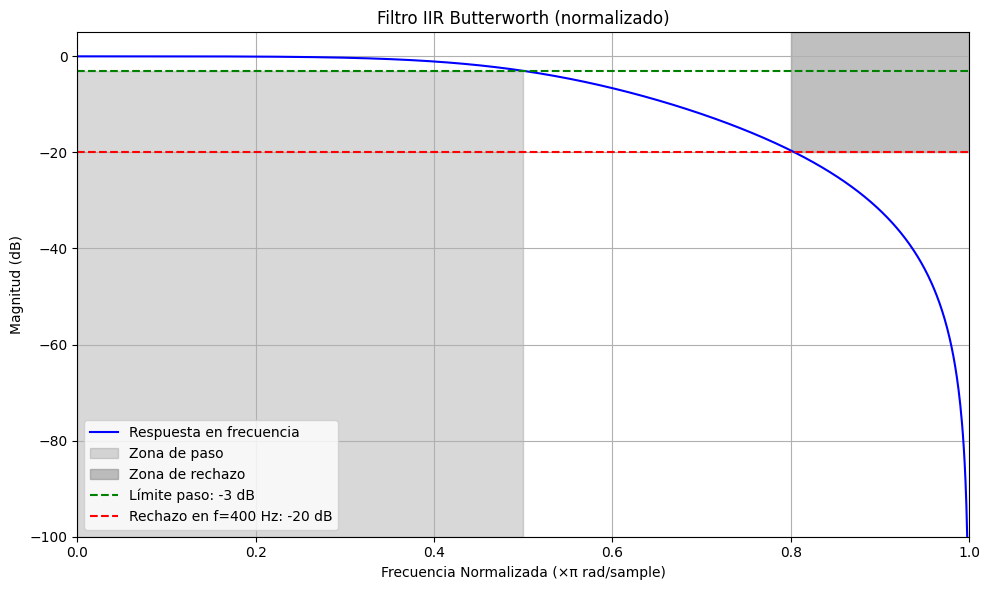

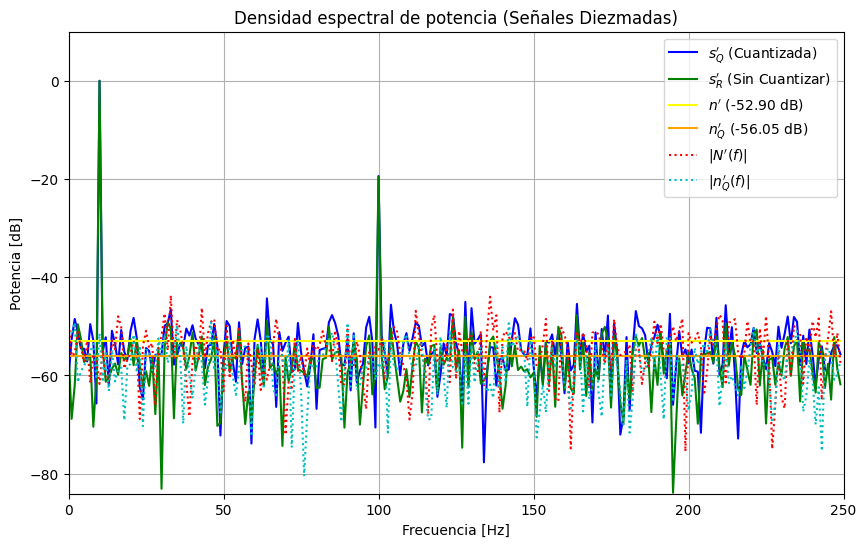

In [5]:
# --- Parámetros del filtro antialiasing ---
fc = 250  # Frecuencia de corte [Hz]
orden = 2
f_objetivo = 400  # Rechazo deseado a partir de fs/2 (porque el nuevo fs será 500 Hz)
atenuacion_rechazo_db = -20  # Al menos 40 dB de atenuación después de fs/2

# Graficar y obtener coeficientes del filtro
b, a = graficar_filtro_iir_(fc=fc, orden=orden, f_objetivo=f_objetivo,
                            atenuacion_rechazo_db=atenuacion_rechazo_db,
                            atenuacion_paso_db=-3, fs=fs)

# Aplicar el filtro antialiasing a las señales sr y srq antes del diezmado
sr_filtrada = sig.lfilter(b, a, sr)
srq_filtrada = sig.lfilter(b, a, srq)

# --- Diezmado (DESPUÉS del filtrado) ---
k_o = 2  # Factor de diezmado (pasa de fs=1000 a fs=500)

fs_prima = fs / k_o
ts_prima = 1 / fs_prima

# Diezmado
srq_prima = srq_filtrada[::k_o]
sr_prima = sr_filtrada[::k_o]
n_prima = n[::k_o]
nq_prima = srq_prima - sr_prima

# Nuevo vector de tiempo
N_prima = len(srq_prima)
tt_prima = np.arange(N_prima) * ts_prima

# FFTs para señales diezmadas
ff_prima = np.fft.fftfreq(N_prima, d=ts_prima)
ft_Srq_prima = np.fft.fft(srq_prima) / N_prima
ft_SR_prima = np.fft.fft(sr_prima) / N_prima
ft_N_prima = np.fft.fft(n_prima) / N_prima
ft_Nq_prima = np.fft.fft(nq_prima) / N_prima

# Potencias promedio
P_s_prima = np.mean(np.abs(ft_SR_prima)**2)
P_n_prima = np.mean(np.abs(ft_N_prima)**2)
P_nq_prima = np.mean(np.abs(ft_Nq_prima)**2)

# Dominio de frecuencias válido
bfrec_prima = (ff_prima >= 0) & (ff_prima <= fs_prima/2)
ff_valid_prima = ff_prima[bfrec_prima]

# Potencias en dB
n_valor_db_prima = 10 * np.log10(2 * P_n_prima)
nq_valor_db_prima = 10 * np.log10(2 * P_nq_prima)
s_valor_db_prima = 10 * np.log10(2 * P_s_prima)

# Curvas a graficar (versión diezmada)
curvas_prima = [
    ('$s_Q^\prime$ (Cuantizada)', ff_valid_prima, 10 * np.log10(2 * np.abs(ft_Srq_prima[bfrec_prima])**2), 'b', '-'),
    ('$s_R^\prime$ (Sin Cuantizar)', ff_valid_prima, 10 * np.log10(2 * np.abs(ft_SR_prima[bfrec_prima])**2), 'g', '-'),
    ('$n^\prime$ ({:.2f} dB)'.format(n_valor_db_prima), ff_valid_prima, [n_valor_db_prima]*len(ff_valid_prima), 'yellow', '-'),
    ('$n_Q^\prime$ ({:.2f} dB)'.format(nq_valor_db_prima), ff_valid_prima, [nq_valor_db_prima]*len(ff_valid_prima), 'orange', '-'),
    ('$|N^\prime(f)|$', ff_valid_prima, 10 * np.log10(2 * np.abs(ft_N_prima[bfrec_prima])**2), 'r', ':'),
    ('$|n_Q^\prime(f)|$', ff_valid_prima, 10 * np.log10(2 * np.abs(ft_Nq_prima[bfrec_prima])**2), 'c', ':'),
]

# Graficar densidad espectral de potencia (versión diezmada)
plt.figure(figsize=(10, 6))
for titulo, frec, pot, color, estilo in curvas_prima:
    plt.plot(frec, pot, label=titulo, color=color, linestyle=estilo)

plt.title('Densidad espectral de potencia (Señales Diezmadas)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Potencia [dB]')
plt.grid(True)
plt.xlim([0, fs_prima / 2])
plt.ylim((1.5*np.min(10*np.log10(2*np.array([P_nq_prima, P_n_prima, P_s_prima]))), 10))
plt.legend()
plt.show()

A diferencia del caso anterior en este caso se utilizo un filtro anti-alias sin embargo este filtro no logro ser lo suficientemente grande para generar la atenuacion suficiente haciendo que aparesca una señal atenuada en los $100Hz$ la cual no existia en un inicio. A diferrencia del caso anteiror esta esta señal se atenuo notoriamente pero todavia no es suficiente.

### Encontrarse cerca de la señal y comerse parte de la señal
Este efecto en si no demuestra el efecto del alias sino que busca mostrar que no se debe abusar de este filtro debido que el mismo va limita tu ancho de banda y puede llevar a atenuar la señal original como se ve a continuacion

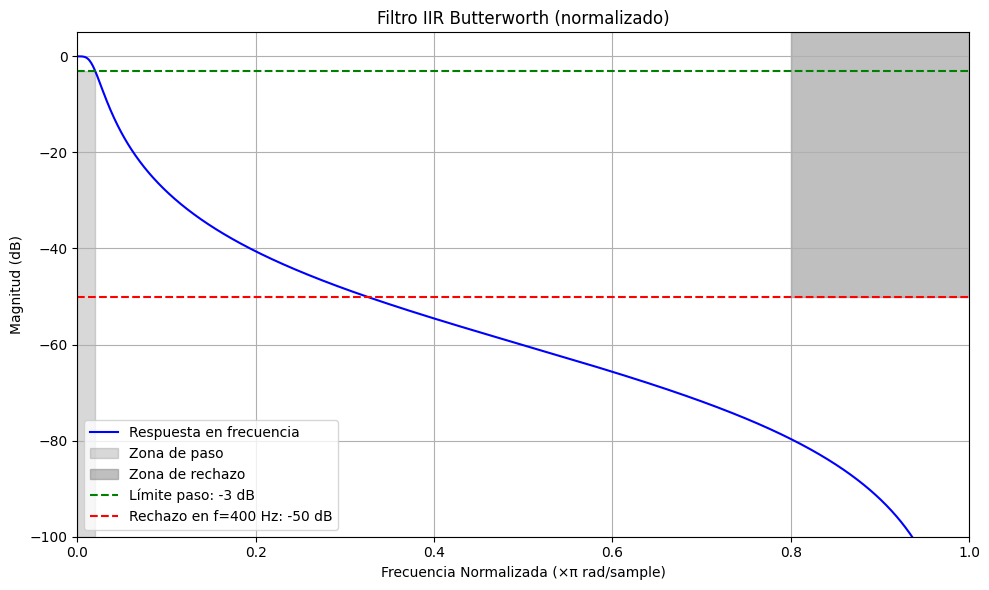

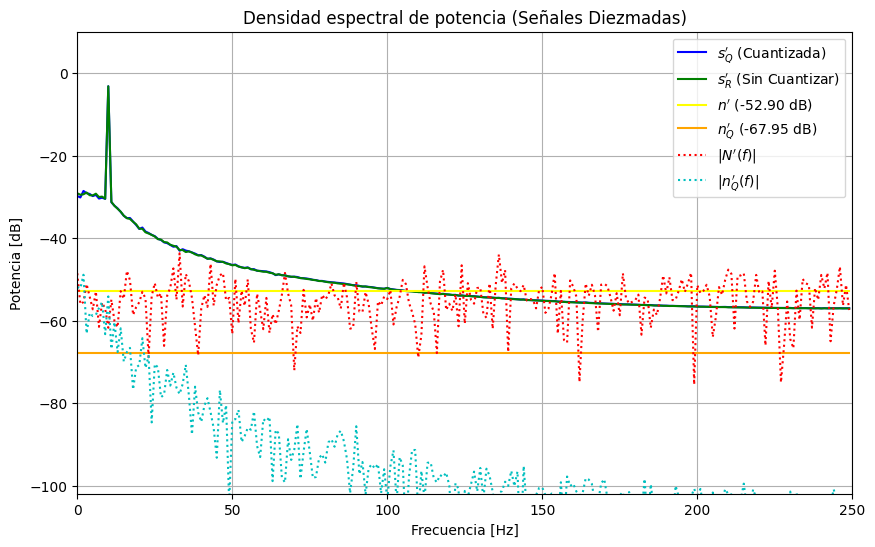

In [6]:
# --- Parámetros del filtro antialiasing ---
fc = 10  # Frecuencia de corte [Hz]
orden = 2
f_objetivo = 400  # Rechazo deseado a partir de fs/2 (porque el nuevo fs será 500 Hz)
atenuacion_rechazo_db = -50  # Al menos 40 dB de atenuación después de fs/2

# Graficar y obtener coeficientes del filtro
b, a = graficar_filtro_iir_(fc=fc, orden=orden, f_objetivo=f_objetivo,
                            atenuacion_rechazo_db=atenuacion_rechazo_db,
                            atenuacion_paso_db=-3, fs=fs)

# Aplicar el filtro antialiasing a las señales sr y srq antes del diezmado
sr_filtrada = sig.lfilter(b, a, sr)
srq_filtrada = sig.lfilter(b, a, srq)

# --- Diezmado (DESPUÉS del filtrado) ---
k_o = 2  # Factor de diezmado (pasa de fs=1000 a fs=500)

fs_prima = fs / k_o
ts_prima = 1 / fs_prima

# Diezmado
srq_prima = srq_filtrada[::k_o]
sr_prima = sr_filtrada[::k_o]
n_prima = n[::k_o]
nq_prima = srq_prima - sr_prima

# Nuevo vector de tiempo
N_prima = len(srq_prima)
tt_prima = np.arange(N_prima) * ts_prima

# FFTs para señales diezmadas
ff_prima = np.fft.fftfreq(N_prima, d=ts_prima)
ft_Srq_prima = np.fft.fft(srq_prima) / N_prima
ft_SR_prima = np.fft.fft(sr_prima) / N_prima
ft_N_prima = np.fft.fft(n_prima) / N_prima
ft_Nq_prima = np.fft.fft(nq_prima) / N_prima

# Potencias promedio
P_s_prima = np.mean(np.abs(ft_SR_prima)**2)
P_n_prima = np.mean(np.abs(ft_N_prima)**2)
P_nq_prima = np.mean(np.abs(ft_Nq_prima)**2)

# Dominio de frecuencias válido
bfrec_prima = (ff_prima >= 0) & (ff_prima <= fs_prima/2)
ff_valid_prima = ff_prima[bfrec_prima]

# Potencias en dB
n_valor_db_prima = 10 * np.log10(2 * P_n_prima)
nq_valor_db_prima = 10 * np.log10(2 * P_nq_prima)
s_valor_db_prima = 10 * np.log10(2 * P_s_prima)

# Curvas a graficar (versión diezmada)
curvas_prima = [
    ('$s_Q^\prime$ (Cuantizada)', ff_valid_prima, 10 * np.log10(2 * np.abs(ft_Srq_prima[bfrec_prima])**2), 'b', '-'),
    ('$s_R^\prime$ (Sin Cuantizar)', ff_valid_prima, 10 * np.log10(2 * np.abs(ft_SR_prima[bfrec_prima])**2), 'g', '-'),
    ('$n^\prime$ ({:.2f} dB)'.format(n_valor_db_prima), ff_valid_prima, [n_valor_db_prima]*len(ff_valid_prima), 'yellow', '-'),
    ('$n_Q^\prime$ ({:.2f} dB)'.format(nq_valor_db_prima), ff_valid_prima, [nq_valor_db_prima]*len(ff_valid_prima), 'orange', '-'),
    ('$|N^\prime(f)|$', ff_valid_prima, 10 * np.log10(2 * np.abs(ft_N_prima[bfrec_prima])**2), 'r', ':'),
    ('$|n_Q^\prime(f)|$', ff_valid_prima, 10 * np.log10(2 * np.abs(ft_Nq_prima[bfrec_prima])**2), 'c', ':'),
]

# Graficar densidad espectral de potencia (versión diezmada)
plt.figure(figsize=(10, 6))
for titulo, frec, pot, color, estilo in curvas_prima:
    plt.plot(frec, pot, label=titulo, color=color, linestyle=estilo)

plt.title('Densidad espectral de potencia (Señales Diezmadas)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Potencia [dB]')
plt.grid(True)
plt.xlim([0, fs_prima / 2])
plt.ylim((1.5*np.min(10*np.log10(2*np.array([P_nq_prima, P_n_prima, P_s_prima]))), 10))
plt.legend()
plt.show()

Como se observa en los graficos superiores al colocar la frecuencia de corte del filtro IIR en $10Hz$ se logro la atenuiacon suficiente en los $400Hz$ logrando desaparecer el efecto del alias. Sin embargo, al colocar la frecuencia de corte tan baja tendremos solo un ancho de banda de unos $10Hz$ con una atenuacion de $3dB$ en los $10Hz$ lo cual limita los usos del ADC, debido a esto al momento diseñar este tipo de filtros se busca obtener el filtro justo y necesario para obtener el mayor ancho de banda sin pero al mismo tiempo reduciendo a lo maximo los efectos de alias.